# Enron Action Item classification 

In [54]:
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.metrics import precision_score,recall_score,f1_score,roc_curve,confusion_matrix
from sklearn.model_selection import train_test_split


In [55]:
def clean_text_through_regex(message):
#     print(row)
    tokens = []
    try:
        for token in message.split():
            token = token.lower()
            token = re.sub("[image]","",token)
            token=re.sub('x-.*:',"",token)
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return " ".join(tokens)

In [56]:
data=pd.read_csv("./final_classifier_data.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7795 entries, 0 to 7794
Data columns (total 2 columns):
sentence           7795 non-null object
actionable_item    7795 non-null bool
dtypes: bool(1), object(1)
memory usage: 68.6+ KB


,sentence,actionable_item
0,Make recommendations including budgets.,True
1,00 east coast nepool 90,False
2,"David, Please change the date on the draft so ...",True
3,christian yoder and steve hall are reviewing t...,False
4,"for further assistance with unsubscribing, yo=...",False


In [57]:
data.loc[data['actionable_item'] ==True, 'actionable_item']=1
data.loc[data['actionable_item']==False,'actionable_item']=0
data.head()

,sentence,actionable_item
0,Make recommendations including budgets.,1
1,00 east coast nepool 90,0
2,"David, Please change the date on the draft so ...",1
3,christian yoder and steve hall are reviewing t...,0
4,"for further assistance with unsubscribing, yo=...",0


In [58]:
#more cleaning
import re
data.sentence.str.replace("[image]","")
data.sentence.str.replace(re.compile("x-.*:"),"")
data.sentence.str.replace(re.compile("<.*>.*</.*>"),"")
data.drop(data[data['sentence'].str.len() < 20].index, inplace = True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7735 entries, 0 to 7794
Data columns (total 2 columns):
sentence           7735 non-null object
actionable_item    7735 non-null object
dtypes: object(2)
memory usage: 181.3+ KB


In [59]:
train, test = train_test_split(data, test_size=0.2)
train,val= train_test_split(train, test_size=0.2)
print("Train set length {}".format(len(train)))
print("Test set length {}".format(len(test)))
print("Val set length {}".format(len(val)))

Train set length 4950
Test set length 1547
Val set length 1238


In [60]:
# A utility method to create a tf.data dataset from a Pandas Dataframe, From : https://www.tensorflow.org/tutorials/structured_data/feature_columns
def df_to_dataset(dataframe, shuffle=True,batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('actionable_item')
  ds = tf.data.Dataset.from_tensor_slices((dataframe['sentence'], labels))

  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe)).batch(batch_size,drop_remainder=True)
  return ds

In [61]:

train_data = df_to_dataset(train,batch_size=128)
val_data = df_to_dataset(val, shuffle=False)
test_data = df_to_dataset(test,shuffle=False)
train_examples_batch=next(iter(df_to_dataset(train,batch_size=10)))


In [62]:
for feature_batch, label_batch in train_data.take(1):
  print('A batch of ages:', feature_batch)
  print('A batch of targets:', label_batch)

A batch of ages: tf.Tensor(
[b'"things should continue along these lines for the rest of the week, because there\'s enough power to get down there but not so much that anyone can flood the market and crush prices," an ecar trader said'
 b', all r= ights reserved about us | contact us | webmaster | site map privacy = policy | terms of service =09'
 b'jeff, i need to see the site plan for burnet'
 b'Interact with cross-functional team to spread around world to work together in entire verification related tasks.'
 b'western spot power prices declined today from a combination of warmer weather across the region and declining natural gas prices'
 b'in this class you will: ascertain when and how to take profit and cut losses'
 b"pat and gary's house looks like it is taking shape fast"
 b'please see the attached spreadsheet for a trade by trade list and a summary'
 b'57) > > balance of funding $ 2,359,041'
 b'we have been working with hewitt and northern trust since july'
 b'frank, the implie

In [63]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
# train_examples_batch[:3]
embedding=hub_layer(train_examples_batch[:3][0])
print(embedding.shape)

(10, 20)


In [64]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_6 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [66]:
history = model.fit(train_data,
                    epochs=30,
                    validation_data=val_data.batch(128,drop_remainder=True),
                    verbose=1,class_weight={1:0.8,2:0.2})

Epoch 1/30
38/38 [==============================] - 1s 32ms/step - loss: 0.5703 - accuracy: 0.7319 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
38/38 [==============================] - 0s 8ms/step - loss: 0.4228 - accuracy: 0.8446 - val_loss: 0.3881 - val_accuracy: 0.8585
Epoch 3/30
38/38 [==============================] - 0s 8ms/step - loss: 0.3553 - accuracy: 0.8602 - val_loss: 0.3410 - val_accuracy: 0.8741
Epoch 4/30
38/38 [==============================] - 0s 8ms/step - loss: 0.3085 - accuracy: 0.8777 - val_loss: 0.3027 - val_accuracy: 0.8906
Epoch 5/30
38/38 [==============================] - 0s 7ms/step - loss: 0.2693 - accuracy: 0.8966 - val_loss: 0.2684 - val_accuracy: 0.9028
Epoch 6/30
38/38 [==============================] - 0s 7ms/step - loss: 0.2275 - accuracy: 0.9196 - val_loss: 0.2372 - val_accuracy: 0.9167
Epoch 7/30
38/38 [==============================] - 0s 7ms/step - loss: 0.1911 - accuracy: 0.9350 - val_loss: 0.2093 - val_accuracy: 0.9245
Epoch 8/30


### Test Accuracies and Other Metrics

In [67]:


x,y=next(iter(test_data.batch(1547,drop_remainder=True)))
predicted=model.predict_on_batch(x)
results = model.evaluate(test_data.batch(1547), verbose=2)
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))# 
tp=0
tn=0
y_pred=[]
for row,val in enumerate(y):
    if predicted[row]>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

con_mat=confusion_matrix(y, y_pred)
print("-------------------------------")
print("Precision", precision_score(y, y_pred))
print("Recall", recall_score(y, y_pred))
print("f1_score", f1_score(y, y_pred))
print("confusion_matrix")
print(con_mat)
print("------------------------------")

1/1 - 0s - loss: 0.1142 - accuracy: 0.9619
loss: 0.114
accuracy: 0.962
-------------------------------
Precision 0.8995983935742972
Recall 0.8682170542635659
f1_score 0.8836291913214991
confusion_matrix
[[1264   25]
 [  34  224]]
------------------------------


In [68]:
model.save('action_item_classifier_nn.h5') 

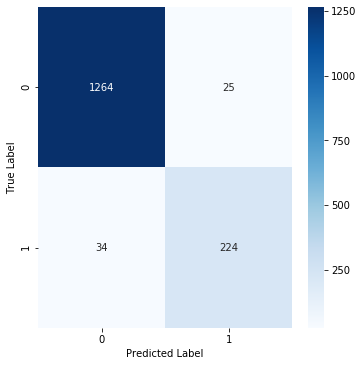

In [70]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

figure=plt.figure(figsize=(5,5))
sns.heatmap(con_mat,annot=True,cmap=plt.cm.Blues,fmt="d")
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [71]:

#load model
model=tf.keras.models.load_model("action_item_classifier_nn.h5",custom_objects={'KerasLayer':hub.KerasLayer})
model.predict(["send me the assignment by today","the figures for enron are solid","can you get me the latest news on the deal"])

array([[0.9825168 ],
       [0.02465788],
       [0.8993523 ]], dtype=float32)

In [72]:
model.predict(["Please update jira task","Updated Jira Task yesterday","Have you updated the jira task yesterday?"])

array([[0.9998393 ],
       [0.86367106],
       [0.76839554]], dtype=float32)

In [73]:
con_mat=[[1272,19],[51 ,205]]
specificity=con_mat[0][0]/(con_mat[0][0]+con_mat[1][0])



In [74]:
specificity

0.9614512471655329